<a href="https://colab.research.google.com/github/AlkaidCheng/GSoC2021_QMLHEP/blob/main/examples/GSoC2021_T02_QGAN_with_QCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1
!pip install tensorflow-quantum
!pip install quple

     |████████████████████████████████| 394.3MB 34kB/s 


In [ ]:
import os
import glob
import operator
import numpy as np
import pandas
import h5py
import tensorflow as tf
import tensorflow_quantum as tfq

In [ ]:
# for reproducibility
tf.random.set_seed(2021)
np.random.seed(2021) 

# Section 1 - Data Preprocessing

## 1.1 Load Photon-Electron data

In [ ]:
# use the cern afs public path or your own path containing the training data
data_dir = "/afs/cern.ch/work/c/chlcheng/public/GSoC2021/data"
photon_path = os.path.join(data_dir, "photon.hdf5")
electron_path = os.path.join(data_dir, "electron.hdf5")

In [ ]:
# load photon data
with h5py.File(photon_path, "r") as f:
    px = np.asarray(f['X'][()], dtype=np.float32)[:,:,:,0]
    py = np.asarray(f['y'][()], dtype=np.float32)

# load electron data
with h5py.File(electron_path, "r") as f:
    ex = np.asarray(f['X'][()], dtype=np.float32)[:,:,:,0]
    ey = np.asarray(f['y'][()], dtype=np.float32)

## 1.2 Image Visualization

In [ ]:
particle_label_map = {
    0: 'photon',
    1: 'electron'
}
import matplotlib.pyplot as plt
def vitualize_image(img, labels, name=None):
    columns = 8
    size = img.shape[0]
    rows = ( size // columns ) + 1
    fig = plt.figure(figsize=(20, rows*3))
    plt.subplots_adjust(hspace=0.3)
    for i in range(img.shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Image {}: {}'.format(i+1, particle_label_map[labels[i]]))
        plt.imshow(img[i])
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    return plt

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

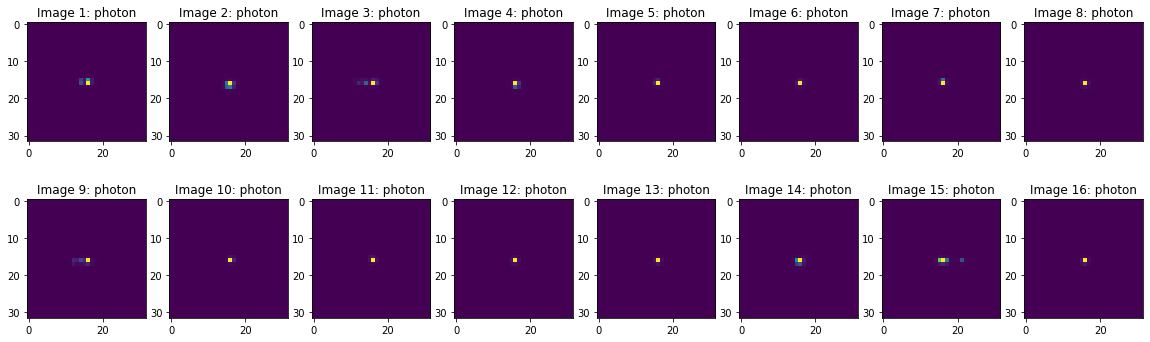

In [ ]:
# let's just visualize the photon image
vitualize_image(px[:16], py[:16], name="images/cnn_raw_image_photon.pdf")

## 1.3 Prepare Training Dataset

- Let's just train on the photon data first and split the data into 75% train and 25% test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(px, py, train_size=0.75, test_size=0.25, random_state=2021)

## 1.4 Image Cropping

Note that the image is
1. Mostly empty except at the center
2. All jets are centered and aligned in the same direction (horizontally)

That means we can crop out the central region of the image without losing much information about the jet. And we don't need to rotate the image.

So by inspection, it should be safe to **crop out the central (8x8) grid**.

In [ ]:
def crop_image(img, dimension):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, dimension))
    end = tuple(map(operator.add, start, dimension))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [ ]:
crop_size = (8, 8)
x_train_cropped = np.array([crop_image(i, crop_size) for i in x_train])
x_test_cropped = np.array([crop_image(i, crop_size) for i in x_test])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

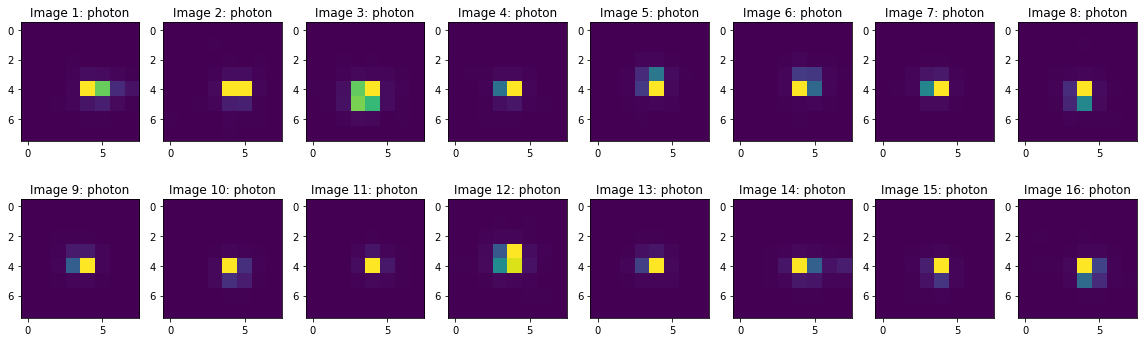

In [ ]:
vitualize_image(x_train_cropped[:16], y_train[:16],  name="images/cnn_cropped_image_photon.pdf")

## 1.6 Rescale data to the range appropriate for quantum data encoding

- Usually classical data is encoded as the rotation angle of a gate operation in a quantum circuit which has a valid range of $[-\pi,+\pi]$. However, from past experience a smaller range will suffice and even show better performance than the valid range itself. So for this task, we will be **rescaling our data to a unit range (i.e. $[0, +1]$)** following the range used by  the`tensorflow_quantum` tutorial for MNIST classification (https://www.tensorflow.org/quantum/tutorials/mnist). Alternative, one may also use another common range $[-1, +1]$ for example from https://arxiv.org/abs/1906.10467.

In [ ]:
def rescale_data(*data, val_range = (0, 1.)):
    min_value = np.min([np.min(d) for d in data])
    max_value = np.max([np.max(d) for d in data])
    range_min = val_range[0]
    range_max = val_range[1]
    rescaled_data = tuple([(((d-min_value)/(max_value-min_value))*(range_max-range_min))+range_min for d in data])
    return rescaled_data
x_train_rescaled, x_test_rescaled = rescale_data(x_train_cropped, x_test_cropped, val_range=(0, 1))

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

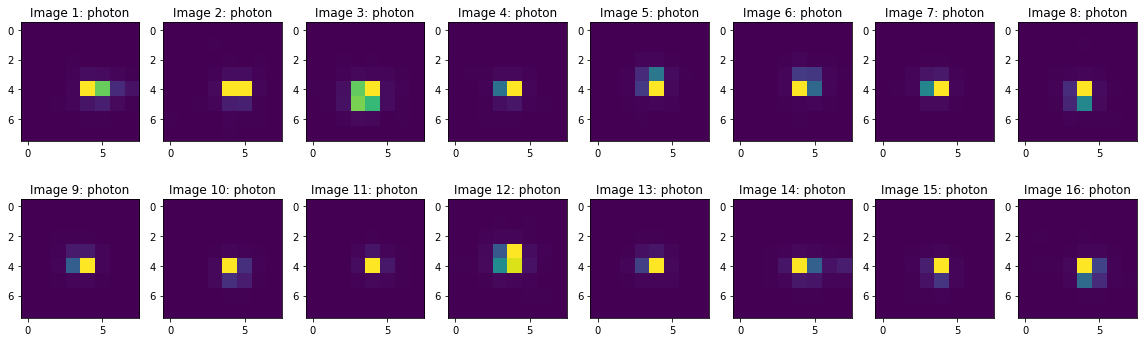

In [ ]:
vitualize_image(x_train_rescaled[:16], y_train[:16],  name="images/cnn_rescaled_image_photon.pdf")

In [ ]:
image_shape = x_train_rescaled.shape[1:]
image_shape

(8, 8)

# Section 2 - QGAN with Classical Generator and QCNN Discriminator

## 2.1 Create classical generator model

In [ ]:
def create_classical_generator():
    model = tf.keras.Sequential()
    # foundation for 2x2 image
    n_nodes = 32 * 2 * 2
    model.add(tf.keras.layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((2, 2, 32)))

    model.add(tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(1,1), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    # upsample to 4x4
    model.add(tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())    
    # upsample to 8x8
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding="same", use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.Reshape((8, 8)))
    return model

In [ ]:
classical_generator = create_classical_generator()

## 2.2 Create QCNN discriminator

- We will use a 3x3 quantum filter in terms of a 9 qubit PQC

In [ ]:
n_qubit = feature_dimension = 9

### Data Encoding Circuit for the 3 x 3 data window

- Just some normal circuit choice taken from the QSVM paper I involved in
- qubit (0, 0) represents top left pixel and qubit (0, 9) represents bottom right pixel

In [ ]:
## deprecated
#from quple.data_encoding import  EncodingCircuit
#from quple import PauliBlock
#from quple.data_encoding import polynomial
#degree = 3

from quple.data_encoding import FirstOrderPauliZEncoding
# create a data circuit for encoding the 3x3 data window
'''
data_circuit = EncodingCircuit(feature_dimension=n_qubit, 
                                copies=2,
                                rotation_blocks=['H',PauliBlock('Z', polynomial(1)),
                                                   PauliBlock('Y',polynomial(degree))],
                                entanglement_blocks=[PauliBlock('ZZ',polynomial(degree))],
                                entangle_strategy='alternate_linear')
'''
data_circuit = FirstOrderPauliZEncoding(feature_dimension=n_qubit, copies=2, parameter_scale=1)
data_circuit

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

(0, 4): ───H───Rz(pi*<x_4/pi>)───H───Rz(pi*<x_4/pi>)───

(0, 5): ───H───Rz(pi*<x_5/pi>)───H───Rz(pi*<x_5/pi>)───

(0, 6): ───H───Rz(pi*<x_6/pi>)───H───Rz(pi*<x_6/pi>)───

(0, 7): ───H───Rz(pi*<x_7/pi>)───H───Rz(pi*<x_7/pi>)───

(0, 8): ───H───Rz(pi*<x_8/pi>)───H───Rz(pi*<x_8/pi>)───

### Kernel Circuit for the Quantum Filter

- Just some random 3x3 = 9 qubit PQC with entanglement

In [ ]:
from quple import ParameterisedCircuit

In [ ]:
kernel_circuit = ParameterisedCircuit(n_qubit=n_qubit, copies=3, 
                                      rotation_blocks=["RZ", "RY"],
                                      entanglement_blocks=["XX"],
                                      entangle_strategy="alternate_linear")
kernel_circuit

(0, 0): ───Rz(θ_0)───Ry(θ_9)────XX──────────Rz(θ_26)────Ry(θ_35)──────────────XX──────────Rz(θ_52)────Ry(θ_61)──────────────XX──────────────────────
                                │                                             │                                             │
(0, 1): ───Rz(θ_1)───Ry(θ_10)───XX^(θ_18)───XX──────────Rz(θ_27)───Ry(θ_36)───XX^(θ_44)───XX──────────Rz(θ_53)───Ry(θ_62)───XX^(θ_70)───XX──────────
                                            │                                             │                                             │
(0, 2): ───Rz(θ_2)───Ry(θ_11)───XX──────────XX^(θ_22)───Rz(θ_28)───Ry(θ_37)───XX──────────XX^(θ_48)───Rz(θ_54)───Ry(θ_63)───XX──────────XX^(θ_74)───
                                │                                             │                                             │
(0, 3): ───Rz(θ_3)───Ry(θ_12)───XX^(θ_19)───XX──────────Rz(θ_29)───Ry(θ_38)───XX^(θ_45)───XX──────────Rz(θ_55)───Ry(θ_64)───XX^(θ_71)───XX──────────
                                            │                                             │                                             │
(0, 4): ───Rz(θ_4)───Ry(θ_13)───XX──────────XX^(θ_23)───Rz(θ_30)───Ry(θ_39)───XX──────────XX^(θ_49)───Rz(θ_56)───Ry(θ_65)───XX──────────XX^(θ_75)───
                                │                                             │                                             │
(0, 5): ───Rz(θ_5)───Ry(θ_14)───XX^(θ_20)───XX──────────Rz(θ_31)───Ry(θ_40)───XX^(θ_46)───XX──────────Rz(θ_57)───Ry(θ_66)───XX^(θ_72)───XX──────────
                                            │                                             │                                             │
(0, 6): ───Rz(θ_6)───Ry(θ_15)───XX──────────XX^(θ_24)───Rz(θ_32)───Ry(θ_41)───XX──────────XX^(θ_50)───Rz(θ_58)───Ry(θ_67)───XX──────────XX^(θ_76)───
                                │                                             │                                             │
(0, 7): ───Rz(θ_7)───Ry(θ_16)───XX^(θ_21)───XX──────────Rz(θ_33)───Ry(θ_42)───XX^(θ_47)───XX──────────Rz(θ_59)───Ry(θ_68)───XX^(θ_73)───XX──────────
                                            │                                             │                                             │
(0, 8): ───Rz(θ_8)───Ry(θ_17)───────────────XX^(θ_25)───Rz(θ_34)───Ry(θ_43)───────────────XX^(θ_51)───Rz(θ_60)───Ry(θ_69)───────────────XX^(θ_77)───

- after 2 convolution with strides = (2, 2), the image dimension will be (2, 2) so we can just use a 4 qubit PQC for the final output

In [ ]:
from quple.data_encoding import  EncodingCircuit
from quple import PauliBlock
from quple.data_encoding.encoding_maps import polynomial
degree = 3
# create a data circuit for encoding the 3x3 data window
"""
output_data_circuit = EncodingCircuit(feature_dimension=4, 
                                copies=2,
                                rotation_blocks=['H',PauliBlock('Z', polynomial(1)),
                                                   PauliBlock('Y',polynomial(degree))],
                                entanglement_blocks=[PauliBlock('ZZ',polynomial(degree))],
                                entangle_strategy='alternate_linear')
"""
output_data_circuit = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
output_data_circuit

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

In [ ]:
output_model_circuit = ParameterisedCircuit(n_qubit=4, copies=5, 
                                      rotation_blocks=["RZ", "RY"],
                                      entanglement_blocks=["ZZ"])
output_model_circuit

┌──────────────────┐                                                              ┌──────────────────┐                                                              ┌──────────────────┐                                                              ┌──────────────────┐                                                              ┌──────────────────┐
(0, 0): ───Rz(θ_0)───Ry(θ_4)───ZZ─────────ZZ──────────ZZ────────────────────────────────Rz(θ_14)────Ry(θ_18)───ZZ──────────ZZ───────────ZZ────────────────────────────────Rz(θ_28)────Ry(θ_32)───ZZ──────────ZZ───────────ZZ────────────────────────────────Rz(θ_42)────Ry(θ_46)───ZZ──────────ZZ───────────ZZ────────────────────────────────Rz(θ_56)────Ry(θ_60)───ZZ──────────ZZ───────────ZZ────────────────────────────────────────────
                               │          │           │                                                        │           │            │                                                        │           │            │                                                        │           │            │                                                        │           │            │
(0, 1): ───Rz(θ_1)───Ry(θ_5)───ZZ^(θ_8)───┼───────────┼────────ZZ───────────ZZ──────────Rz(θ_15)────Ry(θ_19)───ZZ^(θ_22)───┼────────────┼────────ZZ───────────ZZ──────────Rz(θ_29)────Ry(θ_33)───ZZ^(θ_36)───┼────────────┼────────ZZ───────────ZZ──────────Rz(θ_43)────Ry(θ_47)───ZZ^(θ_50)───┼────────────┼────────ZZ───────────ZZ──────────Rz(θ_57)────Ry(θ_61)───ZZ^(θ_64)───┼────────────┼────────ZZ───────────ZZ──────────────────────
                                          │           │        │            │                                              │            │        │            │                                              │            │        │            │                                              │            │        │            │                                              │            │        │            │
(0, 2): ───Rz(θ_2)───Ry(θ_6)──────────────ZZ^(θ_9)────┼────────ZZ^(θ_11)────┼───────────ZZ──────────Rz(θ_16)───Ry(θ_20)────ZZ^(θ_23)────┼────────ZZ^(θ_25)────┼───────────ZZ──────────Rz(θ_30)───Ry(θ_34)────ZZ^(θ_37)────┼────────ZZ^(θ_39)────┼───────────ZZ──────────Rz(θ_44)───Ry(θ_48)────ZZ^(θ_51)────┼────────ZZ^(θ_53)────┼───────────ZZ──────────Rz(θ_58)───Ry(θ_62)────ZZ^(θ_65)────┼────────ZZ^(θ_67)────┼───────────ZZ──────────
                                                      │                     │           │                                               │                     │           │                                               │                     │           │                                               │                     │           │                                               │                     │           │
(0, 3): ───Rz(θ_3)───Ry(θ_7)──────────────────────────ZZ^(θ_10)─────────────ZZ^(θ_12)───ZZ^(θ_13)───Rz(θ_17)───Ry(θ_21)─────────────────ZZ^(θ_24)─────────────ZZ^(θ_26)───ZZ^(θ_27)───Rz(θ_31)───Ry(θ_35)─────────────────ZZ^(θ_38)─────────────ZZ^(θ_40)───ZZ^(θ_41)───Rz(θ_45)───Ry(θ_49)─────────────────ZZ^(θ_52)─────────────ZZ^(θ_54)───ZZ^(θ_55)───Rz(θ_59)───Ry(θ_63)─────────────────ZZ^(θ_66)─────────────ZZ^(θ_68)───ZZ^(θ_69)───
                                                     └──────────────────┘                                                              └──────────────────┘                                                              └──────────────────┘                                                              └──────────────────┘                                                              └──────────────────┘

In [ ]:
from quple.interface.tfq.layers import QConv2D, PQC
import cirq
import tensorflow as tf
#let's measure the last qubit
readout = [cirq.Z(kernel_circuit.qubits[-1])]
final_readout = [cirq.Z(output_model_circuit.qubits[-1])]

# create the quantum discriminator model
quantum_discriminator = tf.keras.Sequential()
quantum_discriminator.add(tf.keras.layers.Input(shape=(8, 8), dtype=tf.float32))
quantum_discriminator.add(QConv2D(kernel_circuit, data_circuit, readout, kernel_size=(3, 3), strides=(2, 2), padding="same"))
#quantum_discriminator.add(tf.keras.layers.LeakyReLU())
#quantum_discriminator.add(tf.keras.layers.Dropout(0.3))    
quantum_discriminator.add(QConv2D(kernel_circuit, data_circuit, readout, kernel_size=(3, 3), strides=(2, 2), padding="same"))
#quantum_discriminator.add(tf.keras.layers.LeakyReLU())
#quantum_discriminator.add(tf.keras.layers.Dropout(0.3))
quantum_discriminator.add(tf.keras.layers.Flatten())
quantum_discriminator.add(PQC(output_model_circuit, output_data_circuit, final_readout))

## Create QGAN model

In [ ]:
from quple.models import QGAN
qgan = QGAN(classical_generator, quantum_discriminator, encoding_circuit=None,
            latent_dim=100,
            epochs=50, d_lr=5e-3, g_lr=1e-3, random_state=2021, batch_size=32,
            checkpoint_dir="./training_checkpoints/qgan_with_cnn/")

Summary of Generator
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12800     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 2, 2, 32)          4096      
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 32)          128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (Non

In [ ]:
qgan.enable_visualization(image_shape, n_image=16)

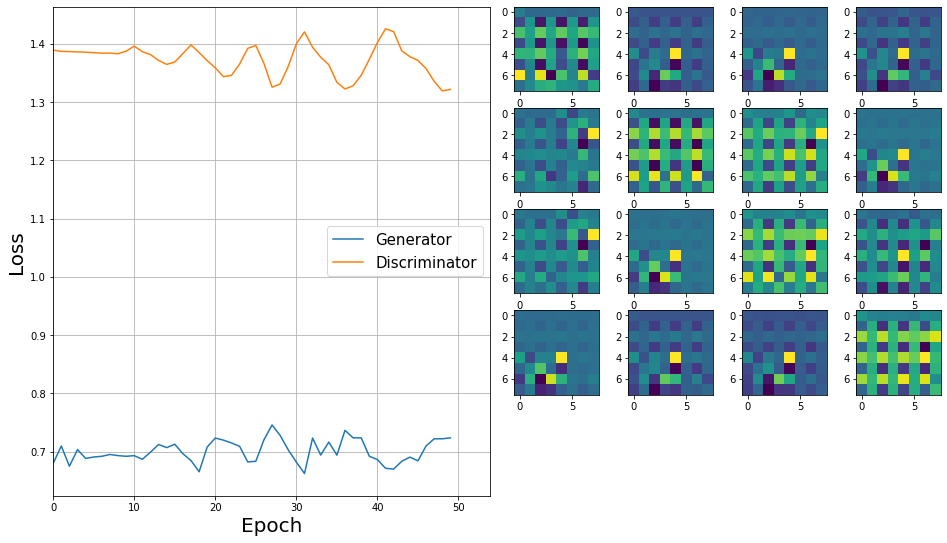

In [ ]:
g_loss, d_loss = qgan.train(x_train_rescaled[:200])